In [ ]:
# Gelişmiş Parquet benchmark: farklı engine ve sıkıştırma seçeneklerini karşılaştırır
# Not: Büyük veri setleri belleği zorlayabilir; varsayılan N değeri makinaya göre azaltılabilir.
import time, os, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# küçük bir örnek için default satır sayısı (gerekirse azaltın)
N = 50_000  # daha küçük denemeler için azaltabilirsiniz
df = pd.DataFrame({'x': np.random.rand(N), 'y': np.random.rand(N)})

# Hangi engine'lerin mevcut olduğunu kontrol et
engines = []
try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    engines.append('pyarrow')
except Exception:
    # pyarrow yoksa uyar ve fastparquet deneyelim
    print('pyarrow bulunamadı; fastparquet veya pandas kullanılacak.')

try:
    import fastparquet
    engines.append('fastparquet')
except Exception:
    print('fastparquet bulunamadı; pandas kullanılacak.')

# Varsayılan olarak en azından pandas ile ('none' -> pandas.to_parquet) çalışsın
if not engines:
    engines = ['none']

compressions = ['none', 'snappy', 'gzip', 'brotli']  # bzip2 genelde çok yavaş; brotli opsiyonel
results = []

for engine in engines:
    for compression in compressions:
        # Geçici dosya oluştur
        tmpf = tempfile.NamedTemporaryFile(suffix='.parquet', delete=False)
        tmpf.close()
        fname = tmpf.name
        write_t = None
        read_t = None
        size = None
        err = None
        try:
            if engine == 'none':
                # pandas (backend auto) kullanarak yazma/okuma
                t0 = time.time()
                df.to_parquet(fname, compression=None if compression=='none' else compression)
                write_t = time.time() - t0
                size = os.path.getsize(fname)
                t0 = time.time()
                _ = pd.read_parquet(fname)
                read_t = time.time() - t0
                engine_name = 'pandas'
            elif engine == 'pyarrow':
                # pyarrow ile doğrudan yazma (table API)
                table = pa.Table.from_pandas(df)
                t0 = time.time()
                pq.write_table(table, fname, compression=None if compression=='none' else compression)
                write_t = time.time() - t0
                size = os.path.getsize(fname)
                t0 = time.time()
                _ = pq.read_table(fname).to_pandas()
                read_t = time.time() - t0
                engine_name = 'pyarrow'
            elif engine == 'fastparquet':
                # fastparquet yazma/okuma
                t0 = time.time()
                # fastparquet.write API: fastparquet.write(filename, df, compression=...)
                fastparquet.write(fname, df, compression=None if compression=='none' else compression)
                write_t = time.time() - t0
                size = os.path.getsize(fname)
                t0 = time.time()
                _ = fastparquet.ParquetFile(fname).to_pandas()
                read_t = time.time() - t0
                engine_name = 'fastparquet'
            else:
                engine_name = str(engine)
        except Exception as e:
            err = str(e)
        finally:
            try:
                os.remove(fname)
            except Exception:
                pass
        results.append({
            'engine': engine_name,
            'compression': compression,
            'write_s': write_t,
            'read_s': read_t,
            'size_bytes': size,
            'error': err
        })

res_df = pd.DataFrame(results)
print('Benchmark sonuçları:')
print(res_df.to_string(index=False))

fastparquet bulunamadı.
Benchmark sonuçları:
 engine compression  write_s   read_s  size_bytes                          error
pyarrow        none 0.060774 0.014661   5359996.0                           None
pyarrow      snappy 0.051695 0.009130   5360274.0                           None
pyarrow        gzip 0.178273 0.014831   5048443.0                           None
pyarrow       bzip2      NaN      NaN         NaN Unsupported compression: bzip2


<Figure size 1000x500 with 0 Axes>

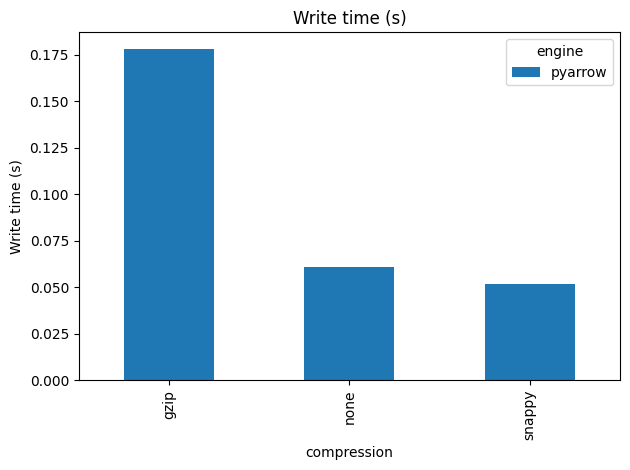

<Figure size 1000x500 with 0 Axes>

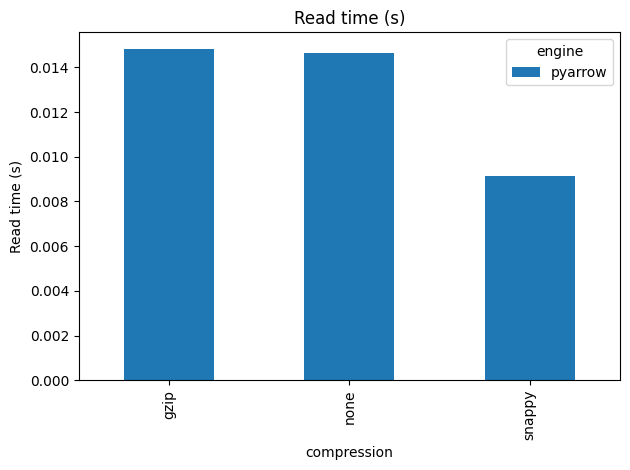

<Figure size 1000x500 with 0 Axes>

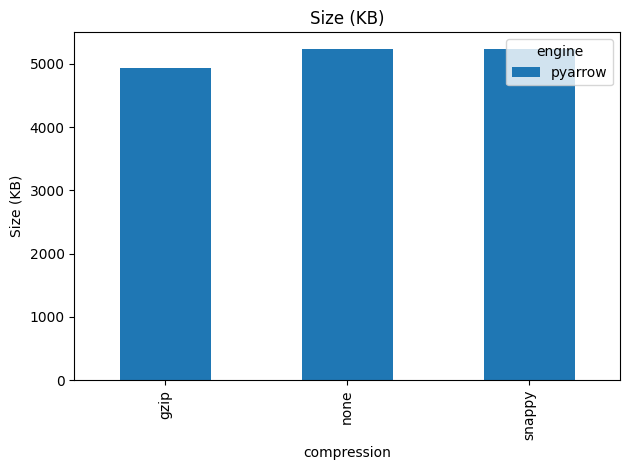

In [2]:
# Görselleştirme: Parquet benchmark sonuçlarını çubuk grafik ile gösterir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'res_df' not in globals():
    print('res_df bulunamadı. Lütfen önce Parquet benchmark hücresini çalıştırın.')
else:
    df = res_df.copy()
    # Hatalı kayıtları filtreleyelim (error dolu olanlar)
    df_ok = df[df['error'].isnull()].copy()
    if df_ok.empty:
        print('Grafik için geçerli sonuç yok (tüm kombinasyonlarda hata oluşmuş).')
    else:
        df_ok['size_kb'] = df_ok['size_bytes'].apply(lambda x: x/1024 if x is not None else np.nan)
        metrics = [('write_s','Write time (s)'), ('read_s','Read time (s)'), ('size_kb','Size (KB)')]
        for col, title in metrics:
            plt.figure(figsize=(10,5))
            try:
                # Pivot table: index=compression, columns=engine, values=col
                pivot = df_ok.pivot(index='compression', columns='engine', values=col)
                pivot.plot(kind='bar')
                plt.title(title)
                plt.xlabel('compression')
                plt.ylabel(title)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print('Grafik oluşturulamadı:', e)

 row_group_size  write_s   read_s  size_bytes error
          16000 0.019246 0.004145     3906430  None
          32000 0.017808 0.004241     3951738  None
          64000 0.029769 0.004528     3998411  None
         128000 0.027449 0.005521     4053545  None


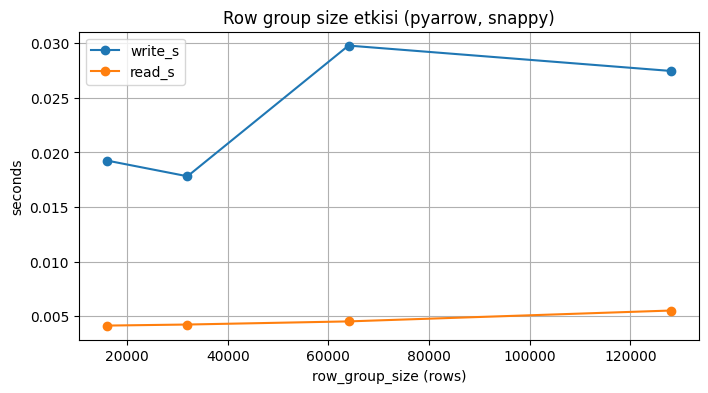

In [3]:
# PyArrow row_group_size (row group) denemeleri
# Bu hücre sadece pyarrow yüklüyse çalışır; farklı row_group_size değerlerinin yazma/okuma üzerindeki etkisini ölçer.
import time, os, tempfile
import numpy as np
import pandas as pd

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
except Exception as e:
    print('pyarrow bulunamadı; row_group_size denemesi için `pip install pyarrow` çalıştırın.', e)

# Küçük bir DataFrame ile test
N = 200_000
df = pd.DataFrame({'x': np.random.rand(N), 'y': np.random.rand(N)})
row_groups = [16_000, 32_000, 64_000, 128_000]  # satır bazlı row group boyutları
results_rg = []
for rg in row_groups:
    tmpf = tempfile.NamedTemporaryFile(suffix='.parquet', delete=False)
    tmpf.close()
    fname = tmpf.name
    write_t = None
    read_t = None
    size = None
    err = None
    try:
        table = pa.Table.from_pandas(df)
        t0 = time.time()
        pq.write_table(table, where=fname, compression='snappy', row_group_size=rg)
        write_t = time.time() - t0
        size = os.path.getsize(fname)
        t0 = time.time()
        _ = pq.read_table(fname).to_pandas()
        read_t = time.time() - t0
    except Exception as e:
        err = str(e)
    finally:
        try:
            os.remove(fname)
        except Exception:
            pass
    results_rg.append({'row_group_size': rg, 'write_s': write_t, 'read_s': read_t, 'size_bytes': size, 'error': err})

import pandas as pd
rg_df = pd.DataFrame(results_rg)
print(rg_df.to_string(index=False))

# Basit görselleştirme
try:
    import matplotlib.pyplot as plt
    rg_df_ok = rg_df[rg_df['error'].isnull()]
    if not rg_df_ok.empty:
        plt.figure(figsize=(8,4))
        plt.plot(rg_df_ok['row_group_size'], rg_df_ok['write_s'], marker='o', label='write_s')
        plt.plot(rg_df_ok['row_group_size'], rg_df_ok['read_s'], marker='o', label='read_s')
        plt.xlabel('row_group_size (rows)')
        plt.ylabel('seconds')
        plt.title('Row group size etkisi (pyarrow, snappy)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print('Row group denemesi için geçerli sonuç yok.')
except Exception as e:
    print('Görselleştirme yapılamadı:', e)